In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from IPython.display import display
from scipy import stats

%matplotlib inline 
np.random.seed(42)

In [2]:
hr_df = pd.read_pickle('hr_df.p')

In [3]:
hr_df['YearsAtCompany'] = hr_df['YearsAtCompany'].replace(0, 0.1)

### Preprocessing

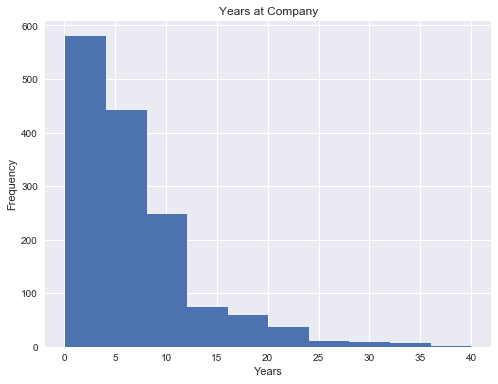

In [4]:
plt.figure(figsize=(8,6))
plt.hist(hr_df['YearsAtCompany'])
plt.title('Years at Company')
plt.xlabel('Years')
plt.ylabel('Frequency')
plt.show()

In [5]:
hr_df['YearsAtCompany'].describe()

count    1470.000000
mean        7.011156
std         6.123122
min         0.100000
25%         3.000000
50%         5.000000
75%         9.000000
max        40.000000
Name: YearsAtCompany, dtype: float64

### Removing outliers
- Anything that is 3 std above the mean

In [6]:
threshold = np.std(hr_df['YearsAtCompany']) * 3 # 3 std above mean
len(hr_df[hr_df['YearsAtCompany'] > np.mean(hr_df['YearsAtCompany']) + threshold])

25

In [7]:
hr_df = hr_df[hr_df['YearsAtCompany'] < np.mean(hr_df['YearsAtCompany']) + threshold]

### Dummy Variables

In [8]:
hr_df = pd.get_dummies(hr_df, drop_first = True) #to avoid multicolinearity

In [9]:
hr_df.head()

,Attrition,Age,DailyRate,DistanceFromHome,HourlyRate,JobLevel,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,...,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes,PerformanceRating_Outstanding,RelationshipSatisfaction_Low,RelationshipSatisfaction_Medium,RelationshipSatisfaction_Very High,WorkLifeBalance_Best,WorkLifeBalance_Better,WorkLifeBalance_Good
0,1,41,1102,1,94,2,5993,19479,8,11,...,0,1,1,0,1,0,0,0,0,0
1,0,49,279,8,61,2,5130,24907,1,23,...,1,0,0,1,0,0,1,0,1,0
2,1,37,1373,2,92,1,2090,2396,6,15,...,0,1,1,0,0,1,0,0,1,0
3,0,33,1392,3,56,1,2909,23159,1,11,...,1,0,1,0,0,0,0,0,1,0
4,0,27,591,2,40,1,3468,16632,9,12,...,1,0,0,0,0,0,1,0,1,0


In [11]:
X = hr_df.drop(['YearsAtCompany'], axis = 1)
y = hr_df['YearsAtCompany']

### Fitting Naive Models

In [39]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler

In [14]:
def fit_benchmark_model(X, y, model, name):
    
    m = model
    #train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
    #scale the data
    scaler = StandardScaler()
    # Fit_transform
    X_train_scaled = scaler.fit_transform(X_train)
    # transform
    X_test_scaled = scaler.transform(X_test)
    
    m.fit(X_train_scaled, y_train)
    
    return (name, 'Train Score:', m.score(X_train_scaled, y_train), 'Test Score:' ,m.score(X_test_scaled, y_test))

In [15]:
fit_benchmark_model(X, y, LinearRegression(), 'Linear Regression')

('Linear Regression',
 'Train Score:',
 0.83567733336774808,
 'Test Score:',
 0.76732553182797514)

### Benchmark $R^2$ = 0.7673

### Tuning Models

In [42]:
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import GridSearchCV

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

#scale the data
scaler = StandardScaler()
# Fit_transform
X_train_scaled = scaler.fit_transform(X_train)
# transform
X_test_scaled = scaler.transform(X_test)

### Ridge

In [23]:
ridge = RidgeCV(alphas = np.logspace(-2,4,7), cv = 10)
ridge.fit(X_train_scaled, y_train)
ridge.alpha_

100.0

In [24]:
ridge.score(X_train_scaled, y_train), ridge.score(X_test_scaled, y_test)

(0.83301149230595561, 0.77376295782522475)

### Lasso

In [25]:
lasso = LassoCV(alphas = np.logspace(-2,4,7), cv = 10)
lasso.fit(X_train_scaled, y_train)
lasso.alpha_

0.10000000000000001

In [26]:
lasso.score(X_train_scaled, y_train), lasso.score(X_test_scaled, y_test)

(0.82530530349294173, 0.7774689290025284)

### Elastic Net

In [27]:
en = ElasticNetCV(alphas = np.logspace(-2,4,7), cv = 10)
en.fit(X_train_scaled, y_train)
en.alpha_

0.10000000000000001

In [28]:
en.score(X_train_scaled, y_train), en.score(X_test_scaled, y_test)

(0.82935169946491616, 0.77607194068035057)

### Decision Tree Regressor

In [37]:
dtr = DecisionTreeRegressor(max_depth=9)
dtr.fit(X_train_scaled, y_train)
dtr.score(X_train_scaled, y_train), dtr.score(X_test_scaled, y_test)

(0.99329449446414575, 0.88092915724549736)

In [52]:
dtparams = {
            'max_depth' : range(1,20),
}

dt_gs = GridSearchCV(DecisionTreeRegressor(), param_grid=dtparams, cv=5,n_jobs=-1)
dt_gs.fit(X_train_scaled, y_train)
dt_gs.best_params_

{'max_depth': 5}

In [53]:
dt_gs.score(X_train_scaled, y_train), dt_gs.score(X_test_scaled, y_test)

(0.93509784765559023, 0.87800021724392685)

### Random Forrest Regressor

In [43]:
rfparams = {
    'n_estimators':[10,50,100,200],
    'max_features':['auto','log2'],
    'max_depth':[1,2,3,4,5,6,7,8,9,10, None]
}

rf_gs = GridSearchCV(RandomForestRegressor(), param_grid=rfparams, cv=5,n_jobs=-1)
rf_gs.fit(X_train_scaled, y_train)
rf_gs.best_params_

{'max_depth': 7, 'max_features': 'auto', 'n_estimators': 50}

In [44]:
rf_gs.score(X_train_scaled, y_train), rf_gs.score(X_test_scaled, y_test)

(0.9758485061794987, 0.89337522330509744)

### Fitting second degree polynomial

In [29]:
from sklearn.preprocessing import PolynomialFeatures

In [30]:
pf_2 = PolynomialFeatures(2)
pf_2.fit(X_train_scaled)
X_train_sc_2 = pf_2.transform(X_train_scaled)
X_test_sc_2 = pf_2.transform(X_test_scaled)

### Ridge

In [31]:
ridge = RidgeCV(alphas = np.logspace(-2,4,7), cv = 10)
ridge.fit(X_train_sc_2, y_train)
ridge.alpha_

100.0

In [32]:
ridge.score(X_train_sc_2, y_train), ridge.score(X_test_sc_2, y_test)

(0.98674163540156745, 0.67010664392801611)

### Lasso

In [33]:
lasso = LassoCV(alphas = np.logspace(-2,4,7), cv = 10)
lasso.fit(X_train_sc_2, y_train)
lasso.alpha_

0.10000000000000001

In [34]:
lasso.score(X_train_sc_2, y_train), lasso.score(X_test_sc_2, y_test)

(0.90676974016706435, 0.85893849092245356)

### Elastic Net

In [35]:
en = ElasticNetCV(alphas = np.logspace(-2,4,7), cv = 10)
en.fit(X_train_sc_2, y_train)
en.alpha_

0.10000000000000001

In [36]:
en.score(X_train_sc_2, y_train), en.score(X_test_sc_2, y_test)

(0.93325846382949729, 0.85083399806697291)

### Random Forrest Regressor

### Fitting 3rd Degree polynomial

In [86]:
pf_3 = PolynomialFeatures(3)
pf_3.fit(X_train_scaled)
X_train_sc_3 = pf_3.transform(X_train_scaled)
X_test_sc_3 = pf_3.transform(X_test_scaled)

In [88]:
X_train_sc_3.shape #34220

(1083L, 34220L)

In [89]:
lasso = LassoCV(alphas = np.logspace(-2,4,7), cv = 5)
lasso.fit(X_train_sc_3, y_train)
lasso.alpha_

C:\Users\Edward\Anaconda2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.10000000000000001

In [90]:
lasso.score(X_train_sc_3, y_train), lasso.score(X_test_sc_3, y_test)

(0.95354959260736405, 0.82502085056386365)

In [105]:
en = ElasticNetCV(alphas = np.logspace(-2,4,7), cv = 5)
en.fit(X_train_sc_3, y_train)
en.alpha_

0.10000000000000001

In [106]:
en.score(X_train_sc_3, y_train), en.score(X_test_sc_3, y_test)

(0.9790597950204657, 0.8096946882684658)

In [ ]:
### best model is lasso with 2nd deg poly alpha = .1

### Feature Importance

In [56]:
rf = RandomForestRegressor(max_depth = 7, max_features = 'auto', n_estimators = 50)
rf.fit(X_train_scaled, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [66]:
zipped = list(zip(X.columns, rf.feature_importances_))
zipped = pd.DataFrame(zipped)
zipped = zipped.sort_values(by = 1)
zipped = zipped.iloc[47:]

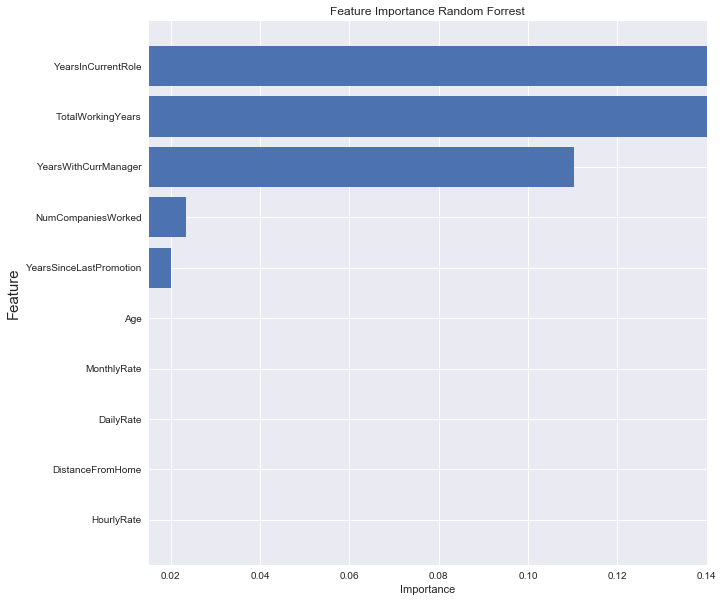

In [69]:
plt.figure(figsize=(10,10))
plt.barh(np.arange(10), zipped[1],)
plt.yticks(np.arange(10), (list(zipped[0])))
plt.ylabel('Feature', fontsize=15)
plt.xlim(xmin = .015, xmax = .14)
plt.xlabel('Importance')
plt.legend()
plt.title('Feature Importance Random Forrest')
plt.show()

In [114]:
best = Lasso(alpha = .1)
best.fit(X_train_sc_2, y_train)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [110]:
def plot_coef(model, top_n = 10):
    '''
    Plots the magnitude of top and bottom n coefficients
    '''
    cols = X_train.columns
    coef = model.coef_
    zipped = list(zip(cols, coef))
    zipped.sort(key=lambda x: x[1], reverse = True)
    top_10 = pd.DataFrame(zipped).head(top_n)
    bottom_10 = pd.DataFrame(zipped).tail(top_n)
    return pd.concat([top_10, bottom_10], axis=0).plot.barh(x = 0, y = 1)

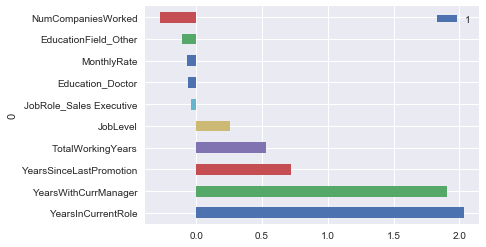

In [117]:
plot_coef(best,top_n = 5)

### Conclusions

#### Comparing Models
| Model                | Parameters                                            | Train $R^2$ | Test $R^{2}$ |
|----------------------|-------------------------------------------------------|-------------|--------------|
| RF                   | max_depth = 7 max_features = 'auto' n_estimators = 50 | 0.9758      | 0.8934       |
| Lasso (2nd deg)      | alpha = .1                                            | 0.9068      | 0.8590       |
| ElasticNet (2nd deg) | alpha = .1                                            | 0.9333      | 0.8508       |
| Lasso (3rd deg)      | alpha = .1                                            | 0.9536      | 0.8250       |
| Linear Regression    | na                                                    | 0.8356      | 0.7673       |

### Important Features
- YearsInCurrentRole
- TotalWorkingYears
- YearsWithCurrentManager
- YearsSinceLastPromotion
- NumCompaniesWorked